### Centro Universitário Senac  
**Professor:** Rafael Cóbe  
**Disciplina:** Introdução ao Aprendizado de Máquina  

### Exercício 4 - **Regressão Linear Multivariada**

**Renato Calabro (calabro@live.com)**
**Ágata Oliveira (agata.aso@hotmail.com)**
**Lucas Parisi (parisi.lucas@gmail.com)**
**Douglas Carvalho Rocha (douglas.particular@gmail.com)**
**Angel Guillermo Morales Romero (aguilhermemr@gmail.com)**

In [1]:
!../.venv/bin/python --version
%pip install -r ../requirements.txt
# %pip install numpy pandas matplotlib seaborn scikit-learn ipkernel
# %pip freeze > requirements.txt
%pip install gdown

Python 3.9.16
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# !mkdir -p data/
# !gdown https://drive.google.com/uc?id=1yHNFuQkro58eBbcfy27aM4IwcGUwHtpO

# baixados manualmente para trabalhar fora do ambiente do Colab autenticado

In [3]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, recall_score, classification_report, mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

import seaborn as sns

In [4]:
from pathlib import Path
base_path = Path("../datasets/roc_auc")

In [5]:
data_path = base_path / "framingham.csv"

if data_path.exists():
    df_raw = pd.read_csv(
        data_path,
        sep=',',
    )
    display(df_raw.head())
else:
    print(f"Arquivo não encontrado: {data_path.resolve()}")

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


#### Exercício

O conjunto de dados está disponível publicamente no Kaggle e é proveniente de um estudo cardiovascular em curso sobre residentes da cidade de Framingham, Massachusetts. O objetivo da classificação é prever se o doente tem um risco de 10 anos de futura doença coronária (CHD). O conjunto de dados fornece as informações dos doentes. Inclui mais de 4.000 registos e 15 atributos.

Cada atributo é um potencial factor de risco. Existem factores de risco demográficos, comportamentais e médicos.

## Tarefas

Explore os dados e crie um classificador de Regressão Logística para prever a variável `TenYearCHD`.
1. Experimente uma combinação de variáveis para construir o melhor classificador.
2. Construir curvas ROC e calcular a AUC para comparar os classificadores.
3. Comparar com os classificadores `SVM` e `KNN`

In [6]:
target = "TenYearCHD"

In [7]:
pd.DataFrame(round(df_raw.isna().sum()*100/len(df_raw),2).sort_values(ascending=False))

,0
glucose,9.16
education,2.48
BPMeds,1.25
totChol,1.18
cigsPerDay,0.68
BMI,0.45
heartRate,0.02
male,0.00
prevalentHyp,0.00
prevalentStroke,0.00


In [8]:
pd.DataFrame(round(df_raw.nunique()*100/len(df_raw),4).sort_values(ascending=False))

,0
BMI,32.1614
totChol,5.8518
sysBP,5.5215
diaBP,3.4450
glucose,3.3742
heartRate,1.7225
age,0.9202
cigsPerDay,0.7787
education,0.0944
prevalentHyp,0.0472


In [9]:
nunique_train=df_raw.nunique().reset_index()
remove_col=nunique_train[(nunique_train[0]==len(df_raw)) | (nunique_train[0]==0) | (nunique_train[0]==1)]['index'].tolist()
remove_col

[]

In [10]:
print("Número de registros com dados faltantes:", df_raw.isnull().any(axis=1).sum())
print("Número de atributos com dados faltantes:", df_raw.isnull().any(axis=0).sum())

Número de registros com dados faltantes: 582
Número de atributos com dados faltantes: 7


In [11]:
# Separar por classe
df_0 = df_raw[df_raw[target] == 0].copy()
df_1 = df_raw[df_raw[target] == 1].copy()

# Criar imputadores KNN separados
imputer_0 = KNNImputer(n_neighbors=5)
imputer_1 = KNNImputer(n_neighbors=5)

# Aplicar imputação (sem a coluna target)
features = df_raw.columns.drop(target)

df_0[features] = imputer_0.fit_transform(df_0[features])
df_1[features] = imputer_1.fit_transform(df_1[features])

# Juntar os dados novamente
df_imputed = pd.concat([df_0, df_1]).sort_index()


In [12]:
print("Número de registros com dados faltantes:", df_imputed.isnull().any(axis=1).sum())
print("Número de atributos com dados faltantes:", df_imputed.isnull().any(axis=0).sum())

Número de registros com dados faltantes: 0
Número de atributos com dados faltantes: 0


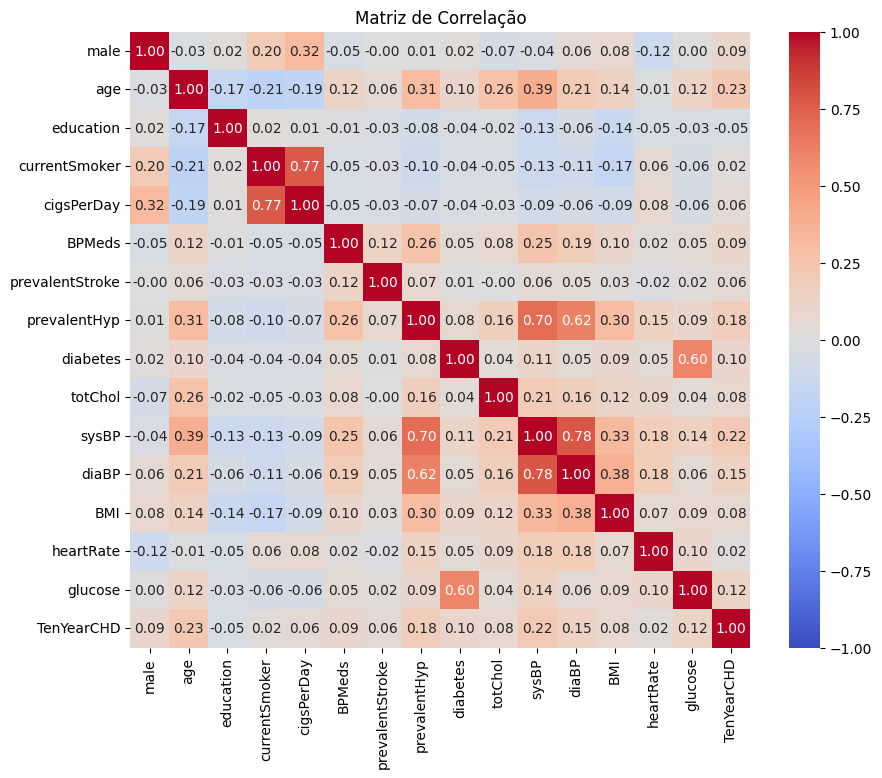

In [13]:
correlation = df_imputed.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()

In [14]:
counts = df_raw["TenYearCHD"].value_counts()
proportions = df_raw["TenYearCHD"].value_counts(normalize=True)

result = pd.DataFrame({
    "Count": counts,
    "Proportion": proportions
})

print(result)

            Count  Proportion
TenYearCHD                   
0            3594    0.848042
1             644    0.151958


In [15]:
# Colunas categóricas binárias
categorical_cols = ['male', 'currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# Colunas numéricas = todas numéricas menos as categóricas + a target
numeric_cols = df_raw.select_dtypes(include='number').columns.difference(categorical_cols + ['TenYearCHD']).tolist()

print("Colunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Colunas categóricas: ['male', 'currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes']
Colunas numéricas: ['BMI', 'BPMeds', 'age', 'cigsPerDay', 'diaBP', 'education', 'glucose', 'heartRate', 'sysBP', 'totChol']


In [16]:
feature_sets = {
    "core": ["age", "sysBP", "glucose"],
    "pressure": ["sysBP", "diaBP", "glucose", "totChol"],
    "clinical": ["age", "sysBP", "glucose", "totChol", "prevalentHyp", "BPMeds"],
    "profile": ["age", "sysBP", "glucose", "prevalentHyp", "male"],
    "compact": ["age", "glucose", "prevalentHyp", "BPMeds", "diabetes"]
}

def get_split_by_feature_set(feature_set_name, X, y, random_state=42, test_size=0.2):
    if feature_set_name not in feature_sets:
        raise ValueError(f"Unknown feature set name: {feature_set_name}")
    
    selected_features = feature_sets[feature_set_name]
    X_selected = X[selected_features]
    
    return train_test_split(
        X_selected, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )


In [17]:
X = df_imputed.drop(columns=[target])
y = df_imputed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
def build_scaler_with_ohe(scaler):
    return ColumnTransformer([
        ('num', scaler, numeric_cols),
        ('cat', OneHotEncoder(drop='if_binary'), categorical_cols)
    ])

pipeline = ImbPipeline([
    ('scaler', 'passthrough'),  # será substituído via grid
    ('smote', 'passthrough'),
    ('clf', LogisticRegression())
])

lr_params = {
    'scaler': [
        build_scaler_with_ohe('passthrough'),
        build_scaler_with_ohe(StandardScaler()),
        build_scaler_with_ohe(MinMaxScaler())
    ],
    'smote': [
        'passthrough',
        SMOTE(random_state=42),
        BorderlineSMOTE(random_state=42)
    ],
    'clf': [
        LogisticRegression(solver='liblinear', max_iter=1000),
        LogisticRegression(solver='saga', max_iter=1000)
    ],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=lr_params,
    scoring=make_scorer(recall_score, pos_label=1), # usar recall para minimizar falsos negativos
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [19]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

grid_search.fit(X_train, y_train)

print("\n✅ Melhor combinação de parâmetros:")
print(grid_search.best_params_)
print("\nMelhor Recall (validação):", grid_search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits



✅ Melhor combinação de parâmetros:
{'clf': LogisticRegression(max_iter=1000, solver='liblinear'), 'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'scaler': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['BMI', 'BPMeds', 'age', 'cigsPerDay', 'diaBP',
                                  'education', 'glucose', 'heartRate', 'sysBP',
                                  'totChol']),
                                ('cat', OneHotEncoder(drop='if_binary'),
                                 ['male', 'currentSmoker', 'prevalentStroke',
                                  'prevalentHyp', 'diabetes'])]), 'smote': 'passthrough'}

Melhor Recall (validação): 0.7514563106796117


In [20]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary'), categorical_cols)
])

# Melhor modelo encontrado
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='liblinear',
        penalty='l1',
        C=0.01,
        class_weight='balanced',
        max_iter=1000
    ))
])

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       719
           1       0.23      0.66      0.34       129

    accuracy                           0.61       848
   macro avg       0.57      0.63      0.53       848
weighted avg       0.80      0.61      0.66       848

Confusion Matrix:
[[432 287]
 [ 44  85]]


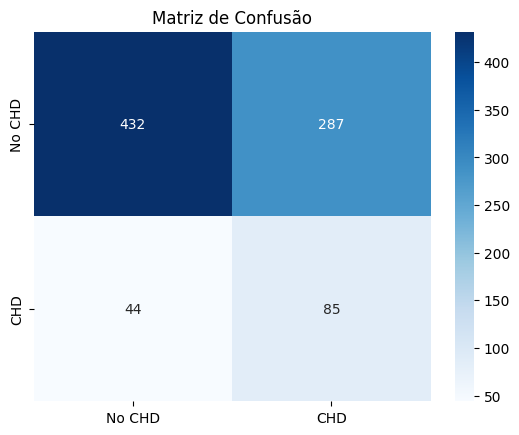

In [21]:
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title("Matriz de Confusão")
plt.show()

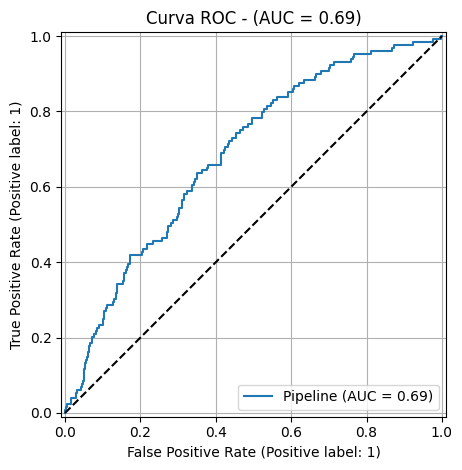

In [22]:

y_proba = best_model.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_estimator(best_model, X_test, y_test)

auc_score = roc_auc_score(y_test, y_proba)

plt.title(f"Curva ROC - (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.grid(True)
plt.tight_layout()
plt.show()